# Analyzing Assessed Value of the Downtown Mall

## Goals: 

    *Provide descriptive statistics of assessed value over time for the City of Charlottesville's downtown mall

    *Map and chart assessed values over time

## Step 1: Aquire Data

### Assessment Values
    Charlottesville's Open Data Portal : http://opendata.charlottesville.org/

    Real Estate (All Assessments) Dataset : http://opendata.charlottesville.org/datasets/real-estate-all-assessments

        * On the Real Estate dataset page, in the upper right corner of the window under the map click the APIs             drop down
        * Copy the GeoJSON link
        * Use the GeoJSON link to pull data directly from the Open Data portal using the code below

    Parcel Area Data : http://opendata.charlottesville.org/datasets/parcel-boundary-area

### List of properties to use in analysis

Charlottesville GIS Viewer: https://gisweb.charlottesville.org/GisViewer/

    * Under Map option, turn on 'Parcels & Buildings' > 'Parcels'. Turn everything else off.

    * Zoom to area of interest on map

    * Under 'Tools' select 'Identify'

    * In 'Identify' toolbar select 'Custom Shape' and under 'Layer' select 'Parcels'

    * Using mouse on map, click boundary around area of interest

    * A list will appear in the left panel of the web page

    * In the panel click 'Tools' > 'Export All to Excel'

    * A window named 'Export Results' will open when your download is ready.

    * Click 'View Export' and save file to your project directory

<img src="https://github.com/strmwtr/downtown_assessments/blob/master/img/getting_pin_list.png?raw=true">

# Step 2: Prepare Data

## Import .xls retrieved from the GIS Viewer into pandas

In [1]:
#Import pandas module
import pandas as pd 

#Path to the .xls retrieve from the GIS Viewer
f = r'./data/pin_exp.xls'

#Create a dataframe that reads the .xls file
df = pd.read_excel(f)

#### Remove all MULTIPIN parcels from df

In [2]:
#Identify all rows in df where MULTIPIN column is not equal to 1
not_multipin = df['MULTIPIN'] != 1
#Create a new dataframe that only contains the rows identified in not_multipin
df = df[not_multipin]
df.head()

,FullAddress,OBJECTID,PIN,GPIN,ParcelNumber,OwnerName,CurrentAssessedValue,CurrentTaxYear,CurrentAssessedValueWithLabel,PicturePath,...,MULTIPIN,OwnerAddress,OwnerCityState,OwnerZipCode,SHAPE.STArea(),SHAPE.STLength(),cvGIS.CITY.parcel_area.CreatedBy,cvGIS.CITY.parcel_area.CreatedDate,cvGIS.CITY.parcel_area.ModifiedBy,cvGIS.CITY.parcel_area.ModifiedDate
0,0 3RD ST SE,24846953,280036300,7309,280036300,"LITTLE MOOSE, LLC",204100,2019 Value:,"2019 Value: 204,100",http://realestate.charlottesville.org/IMAGES\P...,...,NaN,P O BOX 4226,CHARLOTTESVILLE VA,22905,1110.750,178.976929,NaN,NaN,NaN,NaN
1,0 E MARKET ST,24848655,330245100,14744,330245100,FIRST AND MAIN CHARLOTTESVILLE LLC,1122200,2019 Value:,"2019 Value: 1,122,200",NaN,...,NaN,224 14TH STREET NW,CHARLOTTESVILLE VA,22903,11316.250,425.844859,NaN,NaN,NaN,NaN
2,0 W MARKET ST & 2ND ST NW,24841086,330262000,6656,330262000,"SPENCER, HAWES, ETAL, TR PROTICO PROP LD TR",418400,2019 Value:,"2019 Value: 418,400",http://realestate.charlottesville.org/IMAGES\P...,...,NaN,700 E HIGH ST,CHARLOTTESVILLE VA,22902,3802.250,254.696684,NaN,NaN,NaN,NaN
3,100 5TH ST SE,24845005,530065300,7426,530065300,"MAIN, RALPH TR OF BLACK DUCK LD TR",664000,2019 Value:,"2019 Value: 664,000",http://realestate.charlottesville.org/IMAGES\P...,...,NaN,P O BOX 2378,CHARLOTTESVILLE VA,22902,787.375,118.075826,NaN,NaN,NaN,NaN
4,100 E MAIN ST,24839773,280020000,7021,280020000,ONE HUNDRED EAST MAIN LTD PART,1904200,2019 Value:,"2019 Value: 1,904,200",http://realestate.charlottesville.org/IMAGES\P...,...,NaN,MSC BOX 5186,CHARLOTTESVILLE VA,22905,5102.750,418.086500,NaN,NaN,NaN,NaN


## Access json file for parcel areas

In [3]:
formatted_gpins = [str(x) for x in df['GPIN'].unique()]
formatted_gpins = formatted_gpins
formatted_gpins = ','.join(formatted_gpins)

parcel_area_url = f"https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_1/MapServer/43/query?where=GPIN%20in%20({formatted_gpins})&outFields=*&outSR=4326&f=json"

print(parcel_area_url)

https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_1/MapServer/43/query?where=GPIN%20in%20(7309,14744,6656,7426,7021,6984,7197,6819,6876,7447,7029,6724,7511,7484,7042,7005,6807,7515,7543,6923,17202,7128,7541,7199,6805,7120,7111,6877,7047,6569,7053,6958,6674,7082,7037,6668,6930,7063,6666,7213,6740,7078,6897,7279,7091,6726,6966,7104,6806,6869,6633,6881,7272,7068,6703,6947,6832,6625,7141,6604,6696,7162,6393,6694,7171,6848,7346,6537,6662,6493,7017,7330,7025,6655,7033,6644,6861,6689,6267,7232,6979,6918,7059,6938,7249,7070,7259,7087,7096,7266,7103,7275,7308,7163,7510,7319,7329,7339,7185,7348,7072,7198,7358,7207,7374,7390,7441,7456,7471,7664,7482,7717,7507,7524,17098,17097,7184,7476)&outFields=*&outSR=4326&f=json


## Preparing annual assessment data

Charlottesville's Open Data Portal : http://opendata.charlottesville.org/

Real Estate (All Assessments) Dataset : http://opendata.charlottesville.org/datasets/real-estate-all-assessments

* On the Real Estate dataset page, in the upper right corner of the window under the map click the 'API Explorer' tab
* Copy the Query URL link and augment the link to match your query
* Use the augmented link to pull data directly from the Open Data portal using the code below

In [4]:
# importing the requests library 
import requests

formatted_pins = [f'%27{x}%27' for x in df['PIN'].unique()]
formatted_pins_1 = formatted_pins
formatted_pins_1 = ','.join(formatted_pins_1)

url1 = f"https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_2/MapServer/2/query?where=UPPER(ParcelNumber)%20in%20({formatted_pins_1})%20&outFields=ParcelNumber,LandValue,ImprovementValue,TotalValue,TaxYear&outSR=4326&f=json"

r1 = requests.get(url1)

d1 = r1.json()

print(r1)

<Response [200]>


After testing the requests.get(url), I can request up to 120 parcels at a time before recieving a 404 Error. I have 126 parcels of interest. I will break my request up into 2 parts, [:75] and [75:].

## Create data series based on features and combine data frames into a single df

In [5]:
df1 = pd.DataFrame(d1['features'])

## Create a single data frame based on combined series data

In [6]:
assessments = pd.DataFrame([x for x in df1['attributes']], dtype = 'object')
assessments = assessments.astype({'TaxYear': 'int64', 'ImprovementValue': 'int64','LandValue': 'int64','TotalValue': 'int64', 'ParcelNumber': 'str'})
assessments.head()

,ImprovementValue,LandValue,ParcelNumber,TaxYear,TotalValue
0,2924500,3039000,280001000,2019,5963500
1,2752000,2969100,280001000,2018,5721100
2,2826745,2969100,280001000,2017,5795845
3,1746300,2254200,280001000,2016,4000500
4,1746300,2049300,280001000,2015,3795600


## Create data frame from df that holds PIN and GPIN. Will be used to joined assessments, so that parcel area can be joined with assessments

In [7]:
df_key = pd.DataFrame(df[['PIN','GPIN']], dtype = 'str')
df_key.head()

,PIN,GPIN
0,280036300,7309
1,330245100,14744
2,330262000,6656
3,530065300,7426
4,280020000,7021


In [12]:
d = pd.merge(assessments, df_key, how='inner', left_on=['ParcelNumber'], right_on=['PIN'])
print(assessments.shape, d.shape)

(2672, 5) (2672, 7)


# Step 3: Analyze

In [50]:
#Create data frame of assessed values for all parcels by specified year
year_min = int(d['TaxYear'].min())
year_max = int(d['TaxYear'].max())


#year_col = [x for x in range(year_min, year_max + 1)]
#total_val_col = [d['TotalValue'][d['TaxYear'] == x].mean() for x in range(year_min, year_max + 1)]
mean_vals = pd.DataFrame([[year_col, total_val_col]], columns = ['TaxYear','TotalValue'], dtype = 'int64')
#mean_vals = pd.DataFrame(columns = ['TotalValue', 'ImprovementValue', 'LandValue', 'TaxYear'])
mean_vals

#print(d[['TotalValue', 'ImprovementValue', 'LandValue', 'TaxYear' ]][d['TaxYear'] == x].mean())

#x = d['ParcelNumber'].str.contains('2800371C0')
#y = d[x].sort_values('TaxYear')
#y.plot(x='TaxYear', y='TotalValue', figsize=(15,10), grid=True)

,TaxYear,TotalValue
0,"[1997, 1998, 1999, 2000, 2001, 2002, 2003, 200...","[670309.649122807, 694225.4385964912, 737849.1..."


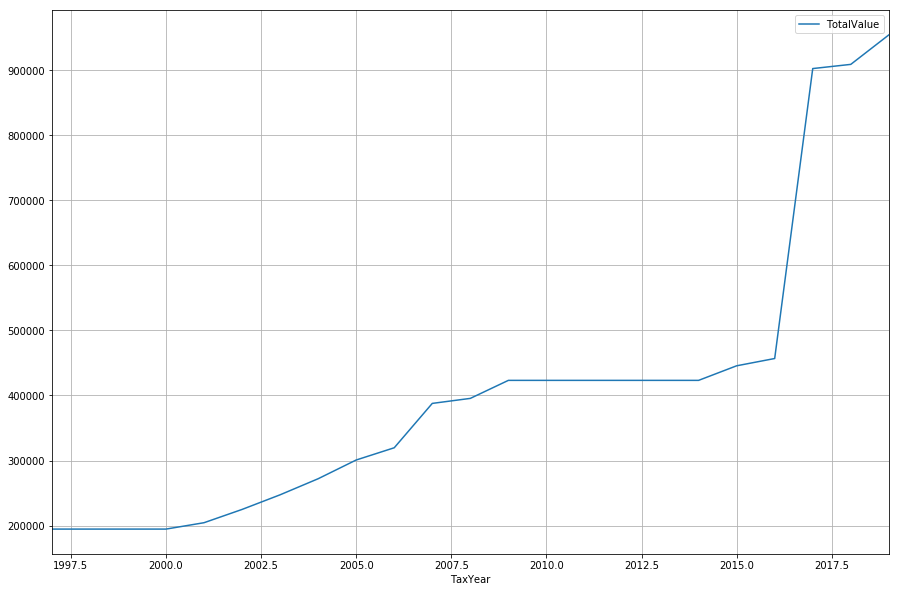

In [11]:
#Plot single parcel by tax year vs total value

x = d['ParcelNumber'].str.contains('2800371C0')
y = d[x].sort_values('TaxYear')
y.plot(x='TaxYear', y='TotalValue', figsize=(15,10), grid=True)

print("\nassessments['ParcelNumber'].describe()\n", assessments['ParcelNumber'].describe())

print("\nassessments['TaxYear'].describe()\n", assessments['TaxYear'].describe())

print("\nassessments['TaxYear'].min(), assessments['TaxYear'].max()\n", assessments['TaxYear'].min(), assessments['TaxYear'].max())

print("\nassessments['ImprovementValue'].describe()\n", assessments['ImprovementValue'].describe())

print("\nassessments['LandValue'].describe()\n", assessments['LandValue'].describe())

print("\nassessments['TotalValue'].describe()\n", assessments['TotalValue'].describe())

taxyearmin = assessments['TaxYear'] == assessments['TaxYear'].min()
assessments[taxyearmin].describe()

taxyearmax = assessments['TaxYear'] == assessments['TaxYear'].max()
assessments[taxyearmax].describe()

## assessments[taxyearmax].describe()-assessments[taxyearmin].describe()

import folium

print(parcel_area_url)

m = folium.Map(location=[38.0309,-78.4804],tiles='Stamen Terrain',zoom_start=17)
folium.GeoJson(parcel_area_url,name='Parcels', style_function=style_function).add_to(m)
folium.LayerControl().add_to(m)
m

# Plot each parcels total, land, and improvement value across all years on 3 line graphs, one for each assessment type

# Map the same data as above via folium

# Create time lapse of maps